# Anime Recommendation System

In [ ]:
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.sparse import csr_matrix


# Data Loading and Preprocessing
Import data from Kaggle and clean the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir= "drive/MyDrive/CIS 519/Project"
ratings_df = pd.read_csv(os.path.join(base_dir, 'ratings_subset.csv'))

In [ ]:
#load anime and rating dataframe
base_dir = "drive/MyDrive/CIS 519 Project/"
# anime_df = pd.read_csv('/content/anime-dataset/anime.csv')
# ratings_df = pd.read_csv('/content/anime-dataset/rating.csv')
anime_df = pd.read_csv(os.path.join(base_dir, 'anime_subset.csv'))
ratings_df = pd.read_csv(os.path.join(base_dir, 'ratings_subset.csv'))

In [ ]:
#load anime and rating dataframe
base_dir = "drive/MyDrive/CIS519/"
anime_df = pd.read_csv(os.path.join(base_dir, 'anime_subset.csv'))
ratings_df = pd.read_csv(os.path.join(base_dir, 'ratings_subset.csv'))

In [ ]:
anime_df.describe()

In [ ]:
ratings_df.describe()

,user_id,anime_id,rating
count,674215.000000,674215.000000,674215.000000
mean,2457.812548,441.225897,7.850009
std,1439.094728,282.713090,1.523782
min,0.000000,0.000000,1.000000
25%,1210.000000,184.000000,7.000000
50%,2451.000000,420.000000,8.000000
75%,3674.000000,676.000000,9.000000
max,4999.000000,999.000000,10.000000


In [ ]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,Military,Super Power,Romance,Shounen,Horror,Kids,School,Fantasy,Mystery,Harem,Seinen,Dementia,Historical,Yaoi,Sci-Fi,Shounen Ai,Hentai,Josei,Vampire,Adventure,Police,Magic,Martial Arts,Space,Psychological,Slice of Life,Mecha,Samurai,Yuri,Game,Demons,Parody,Drama,Supernatural,Sports,Shoujo Ai,Ecchi,Action,Cars,Music,Comedy,Shoujo,Thriller,Movie,TV,OVA,Special,ONA
0,0,Pokemon: Senritsu no Mirage Pokemon,"Adventure, Comedy, Fantasy, Kids",3,1,6.57,13040,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,1,Arslan Senki (TV): Fuujin Ranbu,"Action, Adventure, Drama, Fantasy, Historical,...",1,8,7.70,53577,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,2,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",1,25,8.83,715151,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,3,Fate/stay night: Unlimited Blade Works,"Action, Fantasy, Magic, Shounen, Supernatural",1,12,8.42,267484,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,4,Beelzebub: Hirotta Akachan wa Daimaou!?,"Action, Comedy, Demons, School, Shounen, Super...",3,1,7.34,21212,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0


In [ ]:
genres = set()
for gs in anime_df['genre']:
  for g in gs.split(', '):
    genres.add(g)
print(len(genres))

43


In [ ]:
# onehot encode genre and type
for g in genres:
  anime_df[g] = anime_df['genre'].apply(lambda x: int(g in x))
for t in anime_df['type'].unique():
  anime_df[t] = anime_df['type'].apply(lambda x: int(x == t))

In [ ]:
anime_df['rating'].min()

1.67

In [ ]:
ratings_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


<BarContainer object of 11 artists>

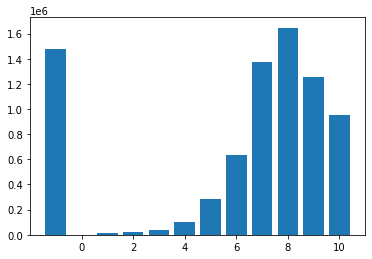

In [ ]:
vc = ratings_df['rating'].value_counts()
plt.bar(vc.index, vc.values)

In [ ]:
ratings = ratings_df.loc[ratings_df['rating'] != -1]

In [ ]:
ratings.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


# Collaborative Filtering

### Setting up train and test set

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD


In [ ]:
train_length = int(len(ratings_df) * 0.8)
test_length = len(ratings_df) - train_length 
train_df = ratings_df.iloc[:train_length]
test_df = ratings_df.iloc[-test_length:]
util_mtx = ratings_df.pivot_table(index='user_id',columns='anime_id',values='rating').fillna(0)
util_mtx_train  = train_df.pivot_table(index='user_id',columns='anime_id',values='rating').fillna(0)
util_mtx_test  = test_df.pivot_table(index='user_id',columns='anime_id',values='rating').fillna(0)

In [ ]:
# find missing anime column in the testing utility matrix
missing = np.setdiff1d(util_mtx_train.columns.values,util_mtx_test.columns.values)
missing

array([ 96, 265, 593, 867])

In [ ]:
# recreate utility matrix with no missing anime
new_ratings_df = ratings_df.append(pd.concat([pd.DataFrame([[0,i,0]], columns=['user_id','anime_id','rating']) for i in missing]),ignore_index=True)
new_test_df = new_ratings_df.iloc[-(len(new_ratings_df)-train_length):]
util_mtx_test  = new_test_df.pivot_table(index='user_id',columns='anime_id',values='rating').fillna(0)

### Using KNN


In [ ]:
def create_mean_center(sparse):
  a = sparse.copy()
  shape = sparse.shape
  row_sums = np.array(sparse.sum(axis=1))[:,0]
  cts=np.diff(sparse.tocsr().indptr)
  means=row_sums/cts
  mc = np.repeat(means, cts)
  a.data = sparse.data- mc
  return a.toarray()


def mean_rating(user_id,util_mtx):

  return np.mean(util_mtx.loc[user_id][util_mtx.loc[user_id]!=0])


def nb_weight_rating(neighbor_index,similarities):

  nb_mean = np.zeros(shape = (sparse.shape[1]))

  for i in range(len(neighbor_index)):
    weight = similarities[i]/similarities.sum()
    #mean_centered_train are the mean centered ratings in training set
    nb_mean += mean_centered_train[neighbor_index[i]]* weight

  return nb_mean

In [ ]:
def NN_Cluster(rating):
  dis, ind =nn.kneighbors(rating)
  return ind[0][1:], 1 - dis[0][1:]

def prediction_knn(user_id,util_mtx):
  
  rating = util_mtx.loc[user_id].values.reshape(1,-1)
  nb_ind, similarity = NN_Cluster(rating)
  # nb_id = util_mtx.iloc[nb_ind.tolist()].index.values
  predictions = mean_rating(user_id,util_mtx_train) + nb_weight_rating(nb_ind, similarity)

  return  np.around(predictions,3)

def recommend(user_id, n):

  anime_ind = np.argsort(-prediction_knn(user_id,util_mtx))[:n]
  anime_id = util_mtx.iloc[:,anime_ind].columns.values

  return anime_id

def predict_rating(user_id, anime_id):
  ind = util_mtx_train.columns.get_loc(anime_id)
  rating = prediction_knn(user_id,util_mtx=util_mtx)[ind]
  return rating




In [ ]:
def rmse_train(method):
  err_sq = 0
  N = len(train_df)
  users = set(train_df.user_id)

  for user in users:
    
    animes = train_df[train_df.user_id==user].anime_id

    pred = method(user,util_mtx_train)[animes]
    true = util_mtx_train.loc[user,animes]

    err_sq += np.sum(np.square(true-pred))

  return np.sqrt(err_sq/N)

def rmse_test(method):
  err_sq = 0
  N = len(test_df)
  users = set(test_df.user_id)

  for user in tqdm.tqdm(users):
    
    animes = test_df[test_df.user_id==user].anime_id

    pred = method(user,util_mtx_test)[animes]
    true = util_mtx_test.loc[user,animes]

    err_sq += np.sum(np.square(true-pred))
  


  return np.sqrt(err_sq/N)

In [ ]:
sparse = csr_matrix(util_mtx.values)
sparse_train = csr_matrix(util_mtx_train.values)

In [ ]:
#normalized ratings
norm = normalize(sparse, norm='l2', axis=1, copy=True)
norm_train = normalize(sparse_train, norm='l2', axis=1, copy=True)
norm_test = normalize(csr_matrix(util_mtx_test.values), norm='l2', axis=1, copy=True)

In [ ]:
#use whole dataset
nn = NearestNeighbors(metric="cosine",n_neighbors=11,n_jobs=-1)
nn.fit(norm_train)
mean_centered_train = create_mean_center(sparse_train)
recommend(3,5)

array([  9,  21, 270, 968, 567])

### Using KMeans

In [ ]:
svd = TruncatedSVD(n_components=50, n_iter=10, random_state=42)
transformed_train = svd.fit_transform(norm_train)
transformed_test = svd.transform(norm_test)
# transformed_whole = TruncatedSVD(n_components=50, n_iter=10, random_state=42).fit_transform(norm)


kmeans = KMeans(n_clusters=50,init='k-means++',n_jobs = -1)
cluster_train = kmeans.fit_predict(transformed_train)
cluster_test = kmeans.predict(transformed_test)
# cluster_whole = KMeans(n_clusters=50,init='k-means++',n_jobs = -1).fit_predict(transformed_whole)




In [ ]:
cluster_df_train = pd.DataFrame( data = {'user_id':util_mtx_train.index.values,'cluster':cluster_train} )
cluster_df_test = pd.DataFrame( data = {'user_id':util_mtx_test.index.values,'cluster':cluster_test} )
# cluster_df_whole = pd.DataFrame( data = {'user_id':util_mtx.index.values,'cluster':cluster_whole} )
# groups = cluster_df.groupby(by = ["cluster"])
# groups.count()

In [ ]:
def prediction_kmeans_test(user_id, cluster_df):

  num = cluster_df_test[cluster_df_test.user_id==user_id].cluster.values[0]
  group =  cluster_df_test[cluster_df_test.cluster==num]
  group_ratings = util_mtx_train.loc[group.user_id]

  user_ind = util_mtx_test.index.get_loc(user_id)
  # neighbors_id = group.drop(user_id,axis = 0).user_id
  neighbors_ind = group.drop(user_ind,axis = 0).index.values
  
  similarity = cosine_similarity(group_ratings)[0][1:]
  predictions = mean_rating(user_id,util_mtx_train) + nb_weight_rating(neighbors_ind, similarity)

  return np.around(predictions,3)

# def prediction_kmeans(user_id,cluster_df = cluster_df_whole):
def prediction_kmeans(user_id,cluster_df):

  num = cluster_df[cluster_df.user_id==user_id].cluster.values[0]
  group =  cluster_df[cluster_df.cluster==num]
  group_ratings = util_mtx.loc[group.user_id]

  user_ind = util_mtx.index.get_loc(user_id)
  # neighbors_id = group.drop(user_id,axis = 0).user_id
  neighbors_ind = group.drop(user_ind,axis = 0).index.values
  
  similarity = cosine_similarity(group_ratings)[0][1:]
  predictions = mean_rating(user_id,util_mtx) + nb_weight_rating(neighbors_ind, similarity)

  return np.around(predictions,3)


def recommend_kmeans(user_id, n):

  anime_ind = np.argsort(-prediction_kmeans(user_id, cluster_df_train))[:n]
  anime_id = util_mtx.iloc[:,anime_ind].columns.values

  return anime_id

def predict_rating_kmeans(user_id, anime_id):
  ind = util_mtx.columns.get_loc(anime_id)
  rating = prediction_kmeans(user_id, cluster_df_train)[ind]
  return rating



In [ ]:
def rmse_test_kmeans(method):
  err_sq = 0
  N = len(test_df)
  users = set(test_df.user_id)

  for user in tqdm.tqdm(users):
    
    animes = test_df[test_df.user_id==user].anime_id

    pred = method(user,cluster_df_test)[animes]
    true = util_mtx_test.loc[user,animes]

    err_sq += np.sum(np.square(true-pred))

  return np.sqrt(err_sq/N)

def rmse_train_kmeans(method):
  err_sq = 0
  N = len(train_df)
  users = set(train_df.user_id)

  for user in tqdm.tqdm(users):
    animes = train_df[train_df.user_id==user].anime_id

    pred = method(user,cluster_df_train)[animes]
    true = util_mtx_train.loc[user,animes]

    err_sq += np.sum(np.square(true-pred))

  return np.sqrt(err_sq/N)



In [ ]:
# use whole dataset to predict scores
prediction_kmeans(0,cluster_df_train)
recommend_kmeans(0,5)
predict_rating_kmeans(0,19)

9.013

### RMSE on test dataset

In [ ]:
import tqdm

In [ ]:
#for testing, using only the training data to predict test data
nn = NearestNeighbors(metric="cosine",n_neighbors=11,n_jobs=-1)
nn.fit(norm_train)
mean_centered_train = create_mean_center(sparse_train)
print(rmse_test(prediction_knn))

100%|██████████| 4966/4966 [09:12<00:00,  8.99it/s]

1.2230122841495883


In [ ]:
# for testing, use training dataset to predict test data
print(rmse_test_kmeans(prediction_kmeans_test))

100%|██████████| 4966/4966 [10:33<00:00,  7.83it/s]

1.2773952713138697


# Content-based Methods

### cleaning and preprocessing the anime dataset

In [ ]:
#import data
#anime_df = pd.read_csv('anime.csv')
##anime_df['type'] = anime_df['type'].fillna('nan')
#drop null values
#anime_df.dropna(inplace=True)
anime_new_df = anime_df[['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members']].copy()

In [ ]:
#replace string features with integers. 
types = {'Movie':0, 'TV':1, 'OVA':2, 'Special':3, 'Music':4, 'ONA':5}
anime_new_df.type = [types[item] for item in anime_df.type]

In [ ]:
#convert list of genres to a string
anime_new_df['genre'] = anime_new_df['genre'].astype('str')
anime_new_df['genre'] = anime_new_df['genre'].str.replace(',', '')

In [ ]:
anime_new_df.head(5)

,anime_id,name,genre,type,episodes,rating,members
0,0,Pokemon: Senritsu no Mirage Pokemon,Adventure Comedy Fantasy Kids,3,1,6.57,13040
1,1,Arslan Senki (TV): Fuujin Ranbu,Action Adventure Drama Fantasy Historical Shou...,1,8,7.70,53577
2,2,Code Geass: Hangyaku no Lelouch,Action Mecha Military School Sci-Fi Super Power,1,25,8.83,715151
3,3,Fate/stay night: Unlimited Blade Works,Action Fantasy Magic Shounen Supernatural,1,12,8.42,267484
4,4,Beelzebub: Hirotta Akachan wa Daimaou!?,Action Comedy Demons School Shounen Supernatural,3,1,7.34,21212


In [ ]:
ave_rating_df = ratings_df.copy()
ave_rating_df = ave_rating_df.drop(columns=['anime_id'])
ave_rating_df = ave_rating_df.groupby('user_id').mean()
ave_rating_df.rename(columns = {'rating': 'ave_rating'}, inplace = False)

,ave_rating
user_id,
0,9.014286
1,7.808511
2,7.227642
3,7.913043
4,7.891304
...,...
4995,8.629630
4996,7.300000
4997,8.091603


In [ ]:
ratings_df = ratings_df.merge(ave_rating_df, on='user_id', how='inner')
ratings_df.rename(columns = {'rating_x': 'user_rating', 'rating_y': 'average'}, inplace = True)

### Recommend top animes that are most similar to the given anime

In [ ]:
#using sklearn CountVextorizer package
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
count_matrix = count.fit_transform(anime_df['genre'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim)

[[1.         0.37796447 0.         ... 0.         0.4472136  0.25      ]
 [0.37796447 1.         0.13363062 ... 0.37796447 0.6761234  0.        ]
 [0.         0.13363062 1.         ... 0.53033009 0.15811388 0.        ]
 ...
 [0.         0.37796447 0.53033009 ... 1.         0.2236068  0.        ]
 [0.4472136  0.6761234  0.15811388 ... 0.2236068  1.         0.        ]
 [0.25       0.         0.         ... 0.         0.         1.        ]]


In [ ]:
#get top 10 recommendations
def get_recommendations(name, cosine_sim=cosine_sim):
  idx = index[name]
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:11]
  anime_idx = [i[0] for i in sim_scores]
  return anime_df['name'].iloc[anime_idx]

In [ ]:
index = pd.Series(anime_df.index, index=anime_df['name']).drop_duplicates()
get_recommendations('Gintama')

775                         Gintama&#039;: Enchousen
792                                          Gintama
874                       Gintama: Shiroyasha Koutan
983                                  Super Milk-chan
391                                 Samurai Champloo
39                            Haiyore! Nyaruko-san W
289                                           Trigun
597                          Trigun: Badlands Rumble
653    Darker than Black: Kuro no Keiyakusha Special
840                            Tetsuwan Birdy Decode
Name: name, dtype: object

### Use TF-IDF of anime genres together with other features to preict rating bsed on anime ids

In [ ]:
#calculating TF-IDF score
from sklearn.feature_extraction.text import TfidfVectorizer
anime_new_df['content'] = anime_new_df['genre'] + anime_new_df['name'].astype(str)
anime_new_df['content'].str.lower()
tfidf = TfidfVectorizer(min_df=0, stop_words='english')
X = tfidf.fit_transform(anime_new_df['content'])
print(X.shape)

(1000, 2062)


In [ ]:
#reduce the dimension since the shape of X is very big
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(100)
reduced_feature = tsvd.fit_transform(X)
reduced_feature_df = pd.DataFrame(reduced_feature, columns=[f"feature{i}" for i in range(100)])
reduced_feature_df.head(5)

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,...,feature60,feature61,feature62,feature63,feature64,feature65,feature66,feature67,feature68,feature69,feature70,feature71,feature72,feature73,feature74,feature75,feature76,feature77,feature78,feature79,feature80,feature81,feature82,feature83,feature84,feature85,feature86,feature87,feature88,feature89,feature90,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99
0,0.151309,-0.053404,0.176245,0.064324,-0.113598,-0.029384,-0.095216,-0.032773,-0.114587,-0.023930,-0.108353,-0.042193,-0.056393,-0.015648,-0.012104,0.052308,-0.022783,0.026677,-0.072537,0.046666,0.033340,-0.061935,0.086962,-0.010790,-0.005309,-0.009466,-0.020120,-0.049396,-0.085930,0.016918,-0.035567,-0.032321,0.056109,0.011329,-0.055238,0.027355,0.011520,-0.026888,0.058544,0.049646,...,-0.002548,0.001073,0.043419,0.033673,0.005218,0.001338,-0.025147,0.053102,-0.018450,-0.020616,-0.008884,0.002546,0.020092,-0.032719,-0.055060,-0.002284,-0.008792,-0.009029,0.007354,-0.006196,-0.000786,-0.026390,-0.013452,-0.001268,0.011302,0.005134,0.001687,-0.000636,0.000946,-0.005741,0.003890,-0.015057,0.026942,0.000146,-0.001765,-0.021618,0.025218,0.009560,0.005860,-0.007965
1,0.221611,-0.100113,0.162756,0.126100,-0.006237,-0.034433,0.056916,0.046970,-0.071073,0.125567,-0.009187,0.022882,0.081484,-0.074316,0.035803,0.005396,0.018078,0.014596,0.009504,0.082608,-0.078827,0.066618,-0.062251,-0.043404,-0.057348,0.092333,-0.035114,0.066219,-0.101805,0.007473,-0.036946,0.015546,-0.066106,-0.054354,-0.009005,0.004875,0.002544,0.221041,-0.057831,-0.051473,...,0.003334,0.007560,-0.007598,-0.037547,-0.028001,-0.017956,0.007144,-0.034954,0.011065,0.009725,-0.005656,0.028568,-0.003102,0.011323,0.012814,0.020518,-0.031173,-0.064297,-0.005833,0.022521,0.020540,-0.018472,-0.001169,-0.025136,-0.004313,-0.029246,0.027989,0.004365,-0.018519,-0.010813,-0.017078,-0.024365,0.016750,0.018255,-0.015303,-0.033475,0.029974,0.046267,0.036818,0.012863
2,0.251446,-0.202291,-0.210146,-0.179153,0.001434,-0.126989,0.031203,0.054378,0.190333,-0.003097,-0.035699,0.033162,-0.019961,0.019870,-0.005295,0.030573,-0.001849,-0.007184,-0.164552,-0.099341,-0.016966,0.032863,0.073792,0.008234,-0.015415,0.038171,-0.004614,0.094617,-0.059719,-0.034403,0.017529,0.019038,-0.006220,0.029122,-0.012885,-0.008271,0.018227,0.005748,-0.018719,-0.012657,...,0.036854,-0.032612,0.030884,0.152045,-0.011392,-0.013651,-0.044363,0.014742,0.020469,0.049143,0.023729,-0.028524,-0.058164,0.072603,0.018417,-0.061907,0.089382,0.003577,-0.031522,-0.016442,-0.010831,-0.018042,-0.073201,-0.098293,0.042548,-0.017119,-0.007104,0.039527,-0.007746,0.098989,0.073752,0.041676,0.173227,0.027482,-0.047652,-0.086525,-0.044558,0.025986,-0.066511,-0.036124
3,0.178146,-0.095783,0.248249,0.042498,-0.045092,0.038713,0.003773,0.211054,0.211235,-0.125399,0.290423,0.033126,0.099410,0.047222,-0.050034,-0.163696,-0.086384,-0.311160,0.046014,0.062376,0.053433,0.043629,-0.099461,-0.206085,-0.225761,0.019908,-0.008071,0.075788,-0.056778,0.150451,-0.267462,0.143083,0.302966,-0.104058,0.026825,0.345739,0.078229,-0.139443,0.056377,0.042828,...,0.005962,0.000465,0.017426,-0.001252,-0.006920,0.008339,0.001035,-0.018161,0.000955,-0.007418,0.008775,-0.012634,0.009987,-0.020901,0.011441,-0.010165,-0.015516,0.043323,0.002098,-0.023409,-0.009692,0.003411,-0.020831,-0.012066,0.017272,-0.025413,-0.008650,0.013795,0.009193,0.028341,0.001183,-0.003707,0.021083,0.004655,-0.005178,-0.004133,-0.005900,0.002315,0.012327,-0.004287
4,0.196004,0.065593,0.088292,-0.042113,0.102105,-0.080160,-0.042313,0.216011,0.006701,0.094651,0.040976,0.065879,0.066468,-0.078908,0.02540

In [ ]:
feature_df = anime_new_df[['anime_id', 'type']]
label = anime_new_df['rating']
feature_df = feature_df.reset_index().drop(columns=['index']).join(reduced_feature_df)

In [ ]:
#split train dataset and test dataset
train_length = int(len(feature_df) * 0.8)
test_length = int(len(feature_df) * 0.2)

train_x = feature_df.iloc[:train_length]
test_x = feature_df.iloc[-test_length:]

train_y = label.iloc[:train_length]
test_y = label.iloc[-test_length:]

In [ ]:
class LinearReg:

    def __init__(self, init_theta=None, alpha=0.01, n_iter=100):
        self.alpha = alpha
        self.n_iter = n_iter
        self.theta = init_theta
        self.JHist = None
    

    def gradientDescent(self, X, y, theta):
        n,d = X.shape
        self.JHist = []
        for i in range(self.n_iter):
            self.JHist.append( (self.computeCost(X, y, theta), theta) )
            #print("Iteration: ", i+1, " Cost: ", self.JHist[i][0], " Theta.T: ", theta.T)
            yhat = X*theta
            theta = theta -  (X.T * (yhat - y)) * (self.alpha / n)
        return theta
    

    def computeCost(self, X, y, theta):
        n,d = X.shape
        # print(X.shape)
        yhat = np.dot(X,theta)
        # print(yhat.shape)
        J =  (yhat-y).T * (yhat-y) / n
        # print(J.shape)
        J_scalar = J.tolist()[0][0]  # convert matrix to scalar
        return J_scalar
    

    def fit(self, X, y):
        n = len(y)
        X = X.to_numpy()
        X = np.c_[np.ones((n,1)), X]     # Add a row of ones for the bias term

        y = y.to_numpy()
        n,d = X.shape
        y = y.reshape(n,1)

        if self.theta is None:
            self.theta = np.matrix(np.zeros((d,1)))

        self.theta = self.gradientDescent(X,y,self.theta)   


    def predict(self, X):
        X = X.to_numpy()
        X = np.c_[np.ones((n,1)), X]     # Add a row of ones for the bias term
        return pd.DataFrame(X*self.theta)

In [ ]:
X = train_x
y = train_y

n,d = X.shape

    # # Standardize features
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = pd.DataFrame(standardizer.fit_transform(X))  # compute mean and stdev on training set for standardization

    # # initialize the model
init_theta = np.matrix(np.random.randn((d+1))).T
alpha = 0.01

    # # Train the model
lr_model = LinearReg(init_theta = init_theta, alpha = alpha, n_iter = 2000)
lr_model.fit(X,y)

In [ ]:
#test the model
X = test_x
y = test_y
n,d = X.shape
# Standardize features
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = pd.DataFrame(standardizer.fit_transform(X))
lr_model.predict(X)

,0
0,8.332550
1,7.780926
2,7.529374
3,7.989367
4,7.647536
...,...
195,7.060738
196,7.626190
197,7.427086
198,7.670070


In [ ]:
#calculate mean square root error
reset_test = test_y.reset_index(drop = True)
#print(reset_test)
test_pred = lr_model.predict(X)
test_pred = test_pred[0]
#print(test_pred)
np.sqrt(np.mean(np.power(test_pred - reset_test, 2)))

0.6483836361599775

In [ ]:
test_pred

0      8.332550
1      7.780926
2      7.529374
3      7.989367
4      7.647536
         ...   
195    7.060738
196    7.626190
197    7.427086
198    7.670070
199    7.486452
Name: 0, Length: 200, dtype: float64

### Combined with user information

In [ ]:
#ratings_df = pd.read_csv('ratings_subset.csv')
ratings_df.head(5)

,user_id,anime_id,user_rating,average
0,0,0,9,9.014286
1,0,163,9,9.014286
2,0,557,9,9.014286
3,0,658,9,9.014286
4,0,835,9,9.014286


In [ ]:
#merge the user information and anime information together
final_df = ratings_df.merge(anime_new_df, on='anime_id', how='inner')
#get tfidf score and reduce dimensinos
tfidf = TfidfVectorizer(min_df=0, stop_words='english')
X = tfidf.fit_transform(final_df['content'])
tsvd = TruncatedSVD(20)
content_features_lr = tsvd.fit_transform(X)
lst = np.cumsum(tsvd.explained_variance_ratio_)
content_feats_df = pd.DataFrame(content_features_lr, columns=[f"desc{i}" for i in range(20)])
content_feats_df.head(5)

,desc0,desc1,desc2,desc3,desc4,desc5,desc6,desc7,desc8,desc9,desc10,desc11,desc12,desc13,desc14,desc15,desc16,desc17,desc18,desc19
0,0.113187,-0.055956,-0.114027,0.042792,-0.04304,-0.017661,0.067114,-0.026598,0.000461,0.020018,-0.011703,-0.038441,0.034109,-0.019803,0.005226,-0.039558,0.025108,-0.025933,0.002823,-0.021766
1,0.113187,-0.055956,-0.114027,0.042792,-0.04304,-0.017661,0.067114,-0.026598,0.000461,0.020018,-0.011703,-0.038441,0.034109,-0.019803,0.005226,-0.039558,0.025108,-0.025933,0.002823,-0.021766
2,0.113187,-0.055956,-0.114027,0.042792,-0.04304,-0.017661,0.067114,-0.026598,0.000461,0.020018,-0.011703,-0.038441,0.034109,-0.019803,0.005226,-0.039558,0.025108,-0.025933,0.002823,-0.021766
3,0.113187,-0.055956,-0.114027,0.042792,-0.04304,-0.017661,0.067114,-0.026598,0.000461,0.020018,-0.011703,-0.038441,0.034109,-0.019803,0.005226,-0.039558,0.025108,-0.025933,0.002823,-0.021766
4,0.113187,-0.055956,-0.114027,0.042792,-0.04304,-0.017661,0.067114,-0.026598,0.000461,0.020018,-0.011703,-0.038441,0.034109,-0.019803,0.005226,-0.039558,0.025108,-0.025933,0.002823,-0.021766


In [ ]:
#get features
feature_df = final_df.reset_index().drop(columns=['index']).join(content_feats_df)
feature_df = feature_df.drop(columns=['rating', 'user_rating','genre', 'name', 'episodes', 'members', 'content', 'anime_id', 'user_id'])
#get label
label = final_df[['user_rating']]

In [ ]:
feature_df.head(5)

,average,type,desc0,desc1,desc2,desc3,desc4,desc5,desc6,desc7,desc8,desc9,desc10,desc11,desc12,desc13,desc14,desc15,desc16,desc17,desc18,desc19
0,9.014286,3,0.113187,-0.055956,-0.114027,0.042792,-0.04304,-0.017661,0.067114,-0.026598,0.000461,0.020018,-0.011703,-0.038441,0.034109,-0.019803,0.005226,-0.039558,0.025108,-0.025933,0.002823,-0.021766
1,7.585799,3,0.113187,-0.055956,-0.114027,0.042792,-0.04304,-0.017661,0.067114,-0.026598,0.000461,0.020018,-0.011703,-0.038441,0.034109,-0.019803,0.005226,-0.039558,0.025108,-0.025933,0.002823,-0.021766
2,7.319797,3,0.113187,-0.055956,-0.114027,0.042792,-0.04304,-0.017661,0.067114,-0.026598,0.000461,0.020018,-0.011703,-0.038441,0.034109,-0.019803,0.005226,-0.039558,0.025108,-0.025933,0.002823,-0.021766
3,6.377224,3,0.113187,-0.055956,-0.114027,0.042792,-0.04304,-0.017661,0.067114,-0.026598,0.000461,0.020018,-0.011703,-0.038441,0.034109,-0.019803,0.005226,-0.039558,0.025108,-0.025933,0.002823,-0.021766
4,7.891892,3,0.113187,-0.055956,-0.114027,0.042792,-0.04304,-0.017661,0.067114,-0.026598,0.000461,0.020018,-0.011703,-0.038441,0.034109,-0.019803,0.005226,-0.039558,0.025108,-0.025933,0.002823,-0.021766


In [ ]:
label.head(5)

,user_rating
0,9
1,7
2,6
3,3
4,8


In [ ]:
#split dataset
train_length = int(len(feature_df) * 0.8)
test_length = int(len(feature_df) * 0.2)

train_x = feature_df.iloc[:train_length]
test_x = feature_df.iloc[-test_length:]

train_y = label.iloc[:train_length]
#valid_y = label.iloc[train_length:train_length+valid_length]
test_y = label.iloc[-test_length:]

In [ ]:
test_feature = ratings_df.iloc[-test_length:]
test_feature = test_feature.reset_index(drop = True)

In [ ]:
#train_model
X = train_x
y = train_y
n,d = X.shape
# # Standardize features
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = pd.DataFrame(standardizer.fit_transform(X))  # compute mean and stdev on training set for standardization
# # initialize the model
init_theta = np.matrix(np.random.randn((d+1))).T
alpha = 0.01
# # Train the model
lr_model = LinearReg(init_theta = init_theta, alpha = alpha, n_iter = 2000)
lr_model.fit(X,y)

In [ ]:
#test model
X = test_x
y = test_y
n,d = X.shape
# Standardize features
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = pd.DataFrame(standardizer.fit_transform(X))
lr_model.predict(X)

,0
0,7.678888
1,8.568655
2,8.740484
3,5.724967
4,8.898945
...,...
134838,8.577571
134839,8.285168
134840,7.265767
134841,8.947463


In [ ]:
#calculate mean square root error
reset_test = test_y.reset_index(drop = True)
reset_test = reset_test['user_rating']
#print(reset_test)
test_pred = lr_model.predict(X)
test_pred = test_pred[0]
#print(test_pred)
np.sqrt(np.mean(np.power(test_pred - reset_test, 2)))

1.354307615801732

In [ ]:
#print(test_pred)
test_res = test_pred.to_frame()
test_res.columns = ['pred_score']

In [ ]:
test_result = test_feature.join(test_res)
test_result = test_result.drop(columns=['user_rating', 'average'])

In [ ]:
test_result.to_csv('content_test.csv')
test_result

,user_id,anime_id,pred_score
0,2982,61,7.678888
1,2982,588,8.568655
2,2982,649,8.740484
3,2982,316,5.724967
4,2982,343,8.898945
...,...,...,...
134838,3429,34,8.577571
134839,3429,282,8.285168
134840,3429,29,7.265767
134841,3429,32,8.947463


# Matrix Factorization Models

In [ ]:
type_dic = {'Movie':0, 'TV':1, 'OVA':2, 'Special':3, 'Music':4, 'ONA':5}
anime_df['type_id'] = anime_df['type'].apply(lambda x: type_dic[x])

In [ ]:
anime_df['members_bin'] = pd.qcut(anime_df['members'], q=[0.1*i for i in range(11)], labels=list(range(10)))
anime_df['rating_bin'] = pd.qcut(anime_df['rating'], q=[0.1*i for i in range(11)], labels=list(range(10)))

In [ ]:
anime_df_bin = anime_df.set_index('anime_id')

In [ ]:
ratings_subset = ratings_df.copy()
ratings_subset.shape

(674215, 3)

In [ ]:
ratings_subset['type_id'] = ratings_subset['anime_id'].apply(lambda x: anime_df_bin.loc[x, 'type_id'])
ratings_subset['rating_bin'] = ratings_subset['anime_id'].apply(lambda x: anime_df_bin.loc[x, 'rating_bin'])
ratings_subset['members_bin'] = ratings_subset['anime_id'].apply(lambda x: anime_df_bin.loc[x, 'members_bin'])

In [ ]:
ratings_subset = ratings_subset[['user_id',	'anime_id',	'type_id',	'rating_bin',	'members_bin',	'rating']]

In [ ]:
ratings_subset.head()

,user_id,anime_id,type_id,rating_bin,members_bin,rating
0,0,0,3,0,1,9
1,1,1,1,5,3,8
2,2,2,1,9,9,9
3,3,3,1,9,8,9
4,4,4,3,3,1,7


In [ ]:
train_length = int(len(ratings_subset) * 0.8)
valid_length = int(len(ratings_subset) * 0.1)
test_length = len(ratings_subset) - train_length - valid_length

train_ratings = ratings_subset.iloc[:train_length]
valid_ratings = ratings_subset.iloc[train_length:train_length+valid_length]
test_ratings = ratings_subset.iloc[-test_length:]

In [ ]:
train_ratings.shape

(539372, 6)

## Matrix Factorization

In [ ]:
num_users = 5000
num_animes = 1000
R_train = np.zeros((num_users, num_animes))

for row in train_ratings.values:
  R_train[row[0], row[1]] = row[-1]

In [ ]:
def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02):
    '''
    R: rating matrix
    P: |U| * K (User features matrix)
    Q: |D| * K (Item features matrix)
    K: latent features
    steps: iterations
    alpha: learning rate
    beta: regularization parameter'''
    Q = Q.T

    for step in range(steps):
        print('step', step)
        # eR = np.dot(P,Q)
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    # calculate error
                    eij = R[i,j] - np.dot(P[i,:],Q[:,j])

                    P[i] = P[i] + alpha * (2 * eij * Q[:,j] - beta * P[i])
                    Q[:,j] = Q[:,j] + alpha * (2 * eij * P[i] - beta * Q[:,j])
                    # for k in range(K):
                    #     # calculate gradient with a and beta parameter
                    #     P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                    #     Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])

        eR = np.dot(P,Q)
        mse = 0
        count = 0
        for row in train_ratings.values:
          mse += (eR[row[0]][row[1]] - row[-1])**2
          count += 1
        print('training mse:', np.sqrt(mse / count))
        mse = 0
        count = 0
        for row in valid_ratings.values:
          mse += (eR[row[0]][row[1]] - row[-1])**2
          count += 1
        print('validation mse:', np.sqrt(mse / count))

    return P, Q.T

In [ ]:
K = 100
P = np.random.normal(size=(num_users, K))
Q = np.random.normal(size=(num_animes, K))

In [ ]:
# np.save(f"drive/MyDrive/CIS 519 Project/P_K{K}.npy", P)
# np.save(f"drive/MyDrive/CIS 519 Project/Q_K{K}.npy", Q)
P = np.load(f"drive/MyDrive/CIS 519 Project/P_K{K}.npy")
Q = np.load(f"drive/MyDrive/CIS 519 Project/Q_K{K}.npy")

In [ ]:
P, Q = matrix_factorization(R_train, P, Q, K, steps=50, alpha=0.001)
# np.save(f"drive/MyDrive/CIS 519 Project/P_K{K}.npy", P)
# np.save(f"drive/MyDrive/CIS 519 Project/Q_K{K}.npy", Q)

step 0
training mse: 0.53594319078236
validation mse: 1.4981963438329995
step 1
training mse: 0.5350457555254873
validation mse: 1.498107466093339
step 2
training mse: 0.5341528328690983
validation mse: 1.4980190215169673
step 3
training mse: 0.5332644032374134
validation mse: 1.4979309891577322
step 4
training mse: 0.532380447065262
validation mse: 1.4978433483979152
step 5
training mse: 0.5315009447990606
validation mse: 1.497756078947007
step 6
training mse: 0.5306258768979476
validation mse: 1.4976691608404664
step 7
training mse: 0.529755223834749
validation mse: 1.4975825744383737
step 8
training mse: 0.5288889660970725
validation mse: 1.4974963004240485
step 9
training mse: 0.5280270841883771
validation mse: 1.4974103198027675
step 10
training mse: 0.5271695586289312
validation mse: 1.4973246139002323
step 11
training mse: 0.5263163699569738
validation mse: 1.4972391643611043
step 12
training mse: 0.5254674987295744
validation mse: 1.497153953147588
step 13
training mse: 0.52462

KeyboardInterrupt: ignored

In [ ]:
P.shape, Q.shape

((5000, 100), (1000, 100))

In [ ]:
mse = 0
count = 0
for i in range(num_users):
  for j in range(num_animes):
    if R_train[i][j] > 0:
      mse += abs(R_pred[i][j] - R_train[i][j])**2
      count += 1
print('training mse:', np.sqrt(mse / count))

training mse: 0.5881541172306441


In [ ]:
R_pred = np.dot(P, Q.T)

In [ ]:
mse = 0
count = 0
for row in train_ratings.values:
  mse += (R_pred[row[0]][row[1]] - row[-1])**2
  count += 1
print('training mse:', np.sqrt(mse / count))

training mse: 0.1856313764409453


In [ ]:
mse = 0
count = 0
for row in valid_ratings.values:
  mse += (R_pred[row[0]][row[1]] - row[-1])**2
  count += 1
print('validation mse:', np.sqrt(mse / count))

validation mse: 1.4128378445068341


In [ ]:
mse = 0
count = 0
preds = []
for row in test_ratings.values:
  mse += (R_pred[row[0]][row[1]] - row[-1])**2
  preds.append(R_pred[row[0]][row[1]])
  count += 1
print('test mse:', np.sqrt(mse / count))

test mse: 1.4127472115196444


In [ ]:
from sklearn.utils.extmath import randomized_svd
U, S, V = randomized_svd(R_train, n_components=100)

In [ ]:
U.shape, S.shape, V.shape

((5000, 100), (100,), (100, 1000))

In [ ]:
R_pred = np.dot(np.dot(U, np.diag(S)), V)

In [ ]:
mse = 0
count = 0
for row in train_ratings.values:
  mse += (R_pred[row[0]][row[1]] - row[-1])**2
  count += 1
print('training mse:', np.sqrt(mse / count))

training mse: 3.9761786802995136


In [ ]:
mse = 0
count = 0
for row in valid_ratings.values:
  mse += (R_pred[row[0]][row[1]] - row[-1])**2
  count += 1
print('training mse:', np.sqrt(mse / count))

training mse: 5.769849446328882


In [ ]:
mse = 0
count = 0
for row in test_ratings.values:
  mse += (R_pred[row[0]][row[1]] - row[-1])**2
  count += 1
print('training mse:', np.sqrt(mse / count))

training mse: 5.783207169571769


Mounted at /content/drive


In [ ]:
mse = 0
count = 0
for i in range(10000):
  for j in range(1000):
    if R[i][j] > 0:
      mse += abs(anime_mean[j] - R[i][j])
      count += 1
mse / count

7.043071321781626

## Factoization Machine & DeepFM

In [ ]:
!pip install torchfm

  Created wheel for torchfm: filename=torchfm-0.7.0-cp37-none-any.whl size=18355 sha256=350d908b70c7e905651912c55ae45aad05ee81d47add50afc084d90c11298dfa
  Stored in directory: /root/.cache/pip/wheels/a8/5c/a7/ba70166196acb8e9f09c8ad6d152500cd4ba1bfb30ce462963
Successfully built torchfm


In [ ]:
import torchfm
from torchfm.dataset.movielens import MovieLens1MDataset, MovieLens20MDataset
from torchfm.model.fm import FactorizationMachineModel
from torchfm.model.nfm import NeuralFactorizationMachineModel

import torch
import tqdm
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader

In [ ]:
class EarlyStopper(object):

    def __init__(self, num_trials, save_path):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.best_accuracy = -float("inf")
        self.save_path = save_path

    def is_continuable(self, model, accuracy, metric):
        if metric == 'loss':
            accuracy = - accuracy
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            self.trial_counter = 0
            torch.save(model, self.save_path)
            return True
        elif self.trial_counter + 1 < self.num_trials:
            self.trial_counter += 1
            return True
        else:
            return False


def train(model, optimizer, data_loader, criterion, device, log_interval=100):
    model.train()
    total_loss = 0
    tk0 = data_loader #data_loader #tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0)
    for i, (fields, target) in enumerate(tk0):
        fields, target = fields.to(device), target.to(device)
        y = model(fields)
        # print(y)
        # print(target)
        # loss = criterion(y, target.float())
        loss = criterion(y, target)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (i + 1) % log_interval == 0:
            # tk0.set_postfix(loss=total_loss / log_interval)
            total_loss = 0

def test(model, data_loader, criterion, device):
    model.eval()
    targets, predicts = list(), list()
    loss = 0
    batches = 0
    with torch.no_grad():
        for fields, target in tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0):
            fields, target = fields.to(device), target.to(device)
            y = model(fields)
            loss+=criterion(y, target).item()
            batches+=1
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
    return loss/batches# roc_auc_score(targets, predicts)

def test_multiclass(model, data_loader, criterion, device):
    model.eval()
    targets, predicts = list(), list()
    loss = 0
    batches = 0
    with torch.no_grad():
        for fields, target in tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0):
            fields, target = fields.to(device), target.to(device)
            target = target * 9 + 1
            y = model(fields) * 9 + 1
            y = torch.round(y)
            loss+=criterion(y, target).item()
            batches+=1
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
    return np.sqrt(loss/batches)# roc_auc_score(targets, predicts)

In [ ]:
class AnimeDataset(torch.utils.data.Dataset):
    """
    MovieLens 20M Dataset
    Data preparation
        treat samples with a rating less than 3 as negative samples
    :param dataset_path: MovieLens dataset path
    Reference:
        https://grouplens.org/datasets/movielens
    """

    def __init__(self, data):
        self.items = data[:, :5].astype(np.int) # -1 because ID begins from 1
        self.targets = (data[:, 5].astype(np.float32) - 1)/9 #self.__preprocess_target(data[:, 2]).astype(np.float32)
        self.field_dims = np.max(self.items, axis=0) + 1
        self.user_field_idx = np.array((0, ), dtype=np.long)
        self.item_field_idx = np.array((1,), dtype=np.long)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

In [ ]:
batch_size=128
learning_rate=0.0001
# weight_decay=1e-5
save_dir='drive/MyDrive/CIS 519 Project'
model_name='fm'
epoch=50
device ='cpu'
embed_dim=128
mlp_dims=(128,)
dropouts=(0.8, 0.8)

In [ ]:
train_dataset = AnimeDataset(train_ratings.values)
valid_dataset = AnimeDataset(valid_ratings.values)
test_dataset = AnimeDataset(test_ratings.values)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

In [ ]:
assert model_name in ['fm', 'dfm']
best_mse = float("inf")
if model_name == 'dfm':
  model = NeuralFactorizationMachineModel(train_dataset.field_dims, embed_dim=embed_dim, mlp_dims=mlp_dims, dropouts=dropouts) 
else:
  model = FactorizationMachineModel(train_dataset.field_dims, embed_dim=embed_dim)

criterion = torch.nn.MSELoss()  #BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
early_stopper = EarlyStopper(num_trials=2, save_path=f'{save_dir}/{model_name}.pt')
for epoch_i in range(epoch):
    train(model, optimizer, train_data_loader, criterion, device)
    mse = test_multiclass(model, valid_data_loader, criterion, device)
    print('epoch:', epoch_i, 'validation: mse:', mse)
    if mse < best_mse:
      if model_name == 'dfm':
        torch.save(model, os.path.join(save_dir, model_name)+f"_{learning_rate}_{embed_dim}_{mlp_dims[0]}_{dropouts[0]}.pt")
      else:
        torch.save(model, os.path.join(save_dir, model_name)+f"_{learning_rate}_{embed_dim}.pt")
      best_mse = mse






  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 296.05it/s]

epoch: 0 validation: mse: 1.8037553114049576







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 296.50it/s]

epoch: 1 validation: mse: 1.5518552277527







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 299.26it/s]

epoch: 2 validation: mse: 1.5135095628434385







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 298.10it/s]

epoch: 3 validation: mse: 1.4932593256517877







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 304.31it/s]

epoch: 4 validation: mse: 1.4759813167112377







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 294.30it/s]

epoch: 5 validation: mse: 1.4612049782751182







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 304.14it/s]

epoch: 6 validation: mse: 1.4491767473872292







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 302.33it/s]

epoch: 7 validation: mse: 1.4384863856169032







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 305.85it/s]

epoch: 8 validation: mse: 1.4305701142696547







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 301.69it/s]

epoch: 9 validation: mse: 1.4223850895376766







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 309.35it/s]

epoch: 10 validation: mse: 1.4147911311553145







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 290.06it/s]

epoch: 11 validation: mse: 1.408816866449432







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 303.38it/s]

epoch: 12 validation: mse: 1.4045547491232855







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 310.54it/s]

epoch: 13 validation: mse: 1.4002945448008615







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 298.26it/s]

epoch: 14 validation: mse: 1.3973076515451102







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 296.16it/s]

epoch: 15 validation: mse: 1.3941796866494744







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 311.01it/s]

epoch: 16 validation: mse: 1.3912519320591126







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 311.30it/s]

epoch: 17 validation: mse: 1.3870825873832775







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 287.41it/s]

epoch: 18 validation: mse: 1.3849403704366376







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 311.40it/s]

epoch: 19 validation: mse: 1.383937885005741







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 307.30it/s]

epoch: 20 validation: mse: 1.3840360772677571







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 302.00it/s]

epoch: 21 validation: mse: 1.3820977369341045







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 309.69it/s]

epoch: 22 validation: mse: 1.383111380535466







  0%|          | 0/527 [00:00<?, ?it/s]



100%|██████████| 527/527 [00:01<00:00, 302.45it/s]

epoch: 23 validation: mse: 1.3845863364905515


In [ ]:
best_model = torch.load(os.path.join(save_dir, model_name)+f"_{learning_rate}_{embed_dim}.pt")
mse = test_multiclass(best_model, test_data_loader, criterion, device)
print(f'test mse: {mse}')

100%|██████████| 527/527 [00:02<00:00, 247.91it/s]

test mse: 1.4282198766603416


In [ ]:
for embed_dim in [32, 64, 128]:
  # model = FactorizationMachineModel(train_dataset.field_dims, embed_dim=embed_dim)
  model = torch.load(os.path.join(save_dir, model_name)+f"_{learning_rate}_{embed_dim}.pt")
  criterion = torch.nn.MSELoss()  #BCELoss()
  print('training mse: ', test_multiclass(model, train_data_loader, criterion, 'cpu'))
  print('test mse: ', test_multiclass(model, test_data_loader, criterion, 'cpu'))





  0%|          | 0/4214 [00:00<?, ?it/s]


  7%|▋         | 281/4214 [00:01<00:14, 279.50it/s]


 14%|█▎        | 571/4214 [00:02<00:12, 284.67it/s]


 20%|██        | 861/4214 [00:03<00:11, 285.62it/s]


 28%|██▊       | 1159/4214 [00:04<00:10, 288.59it/s]


 35%|███▍      | 1457/4214 [00:05<00:09, 290.23it/s]


 42%|████▏     | 1755/4214 [00:06<00:08, 291.20it/s]


 49%|████▉     | 2057/4214 [00:07<00:07, 292.63it/s]


 56%|█████▌    | 2359/4214 [00:08<00:06, 293.66it/s]


 63%|██████▎   | 2661/4214 [00:09<00:05, 293.74it/s]


 70%|███████   | 2964/4214 [00:10<00:04, 294.55it/s]


 78%|███████▊  | 3267/4214 [00:11<00:03, 295.09it/s]


 85%|████████▍ | 3570/4214 [00:12<00:02, 295.64it/s]


 92%|█████████▏| 3874/4214 [00:13<00:01, 296.24it/s]


100%|██████████| 4214/4214 [00:14<00:00, 296.13it/s]



  0%|          | 0/527 [00:00<?, ?it/s]

training mse:  1.6061561494627212





100%|██████████| 527/527 [00:01<00:00, 303.77it/s]



  0%|          | 0/4214 [00:00<?, ?it/s]

test mse:  1.6561096406752063





  7%|▋         | 291/4214 [00:01<00:13, 289.43it/s]


 14%|█▍        | 582/4214 [00:02<00:12, 289.90it/s]


 21%|██        | 873/4214 [00:03<00:11, 288.53it/s]


 28%|██▊       | 1164/4214 [00:04<00:10, 287.36it/s]


 35%|███▍      | 1455/4214 [00:05<00:09, 287.78it/s]


 41%|████▏     | 1746/4214 [00:06<00:08, 287.67it/s]


 48%|████▊     | 2037/4214 [00:07<00:07, 286.87it/s]


 55%|█████▌    | 2328/4214 [00:08<00:06, 286.41it/s]


 62%|██████▏   | 2631/4214 [00:09<00:05, 288.17it/s]


 70%|██████▉   | 2934/4214 [00:10<00:04, 288.92it/s]


 77%|███████▋  | 3237/4214 [00:11<00:03, 288.96it/s]


 84%|████████▍ | 3540/4214 [00:12<00:02, 288.67it/s]


 91%|█████████ | 3843/4214 [00:13<00:01, 289.15it/s]


100%|██████████| 4214/4214 [00:14<00:00, 288.67it/s]



  0%|          | 0/527 [00:00<?, ?it/s]

training mse:  1.3228696315391515





100%|██████████| 527/527 [00:01<00:00, 281.50it/s]



  0%|          | 0/4214 [00:00<?, ?it/s]

test mse:  1.4282198766603416





  6%|▋         | 268/4214 [00:01<00:14, 266.62it/s]


 13%|█▎        | 545/4214 [00:02<00:13, 271.67it/s]


 20%|█▉        | 824/4214 [00:03<00:12, 273.93it/s]


 26%|██▋       | 1107/4214 [00:04<00:11, 276.01it/s]


 33%|███▎      | 1390/4214 [00:05<00:10, 274.50it/s]


 40%|███▉      | 1673/4214 [00:06<00:09, 275.16it/s]


 46%|████▋     | 1956/4214 [00:07<00:08, 273.04it/s]


 53%|█████▎    | 2239/4214 [00:08<00:07, 271.10it/s]


 60%|█████▉    | 2522/4214 [00:09<00:06, 270.91it/s]


 67%|██████▋   | 2805/4214 [00:10<00:05, 270.31it/s]


 73%|███████▎  | 3088/4214 [00:11<00:04, 269.16it/s]


 80%|███████▉  | 3371/4214 [00:12<00:03, 268.82it/s]


 87%|████████▋ | 3654/4214 [00:13<00:02, 268.12it/s]


100%|██████████| 4214/4214 [00:15<00:00, 266.20it/s]



  0%|          | 0/527 [00:00<?, ?it/s]

training mse:  0.9988118995972929





100%|██████████| 527/527 [00:01<00:00, 273.85it/s]

test mse:  1.2694803105359738


In [ ]:
for embed_dim in [32, 64, 128]:
  # model = NeuralFactorizationMachineModel(train_dataset.field_dims, embed_dim=embed_dim, mlp_dims=mlp_dims, dropouts=dropouts) 
  model = torch.load(os.path.join(save_dir, 'dfm')+f"_{learning_rate}_{embed_dim}_128_0.8.pt")
  criterion = torch.nn.MSELoss()  #BCELoss()
  print('training mse: ', test_multiclass(model, train_data_loader, criterion, 'cpu'))
  print('test mse: ', test_multiclass(model, test_data_loader, criterion, 'cpu'))






  0%|          | 0/4214 [00:00<?, ?it/s]



  7%|▋         | 294/4214 [00:01<00:13, 292.28it/s]



 14%|█▍        | 593/4214 [00:02<00:12, 295.89it/s]



 21%|██▏       | 896/4214 [00:03<00:11, 297.74it/s]



 28%|██▊       | 1199/4214 [00:04<00:10, 297.87it/s]



 36%|███▌      | 1502/4214 [00:05<00:09, 295.65it/s]



 43%|████▎     | 1805/4214 [00:06<00:08, 292.24it/s]



 50%|█████     | 2108/4214 [00:07<00:07, 292.56it/s]


 13%|█▎        | 554/4214 [00:13<01:31, 40.21it/s] 



 57%|█████▋    | 2411/4214 [00:08<00:06, 292.48it/s]



 64%|██████▍   | 2714/4214 [00:09<00:05, 293.09it/s]



 72%|███████▏  | 3017/4214 [00:10<00:04, 293.54it/s]



 79%|███████▉  | 3326/4214 [00:11<00:03, 294.87it/s]



 86%|████████▋ | 3635/4214 [00:12<00:01, 295.35it/s]



100%|██████████| 4214/4214 [00:14<00:00, 295.95it/s]




  0%|          | 0/527 [00:00<?, ?it/s]

training mse:  1.3885922586120132






100%|██████████| 527/527 [00:01<00:00, 313.12it/s]




  0%|          | 0/4214 [00:00<?, ?it/s]

test mse:  1.4354696773713636






  7%|▋         | 303/4214 [00:01<00:12, 301.12it/s]



 14%|█▍        | 606/4214 [00:02<00:11, 300.91it/s]



 22%|██▏       | 909/4214 [00:03<00:10, 301.44it/s]



 29%|██▉       | 1212/4214 [00:04<00:09, 301.00it/s]



 36%|███▌      | 1515/4214 [00:05<00:08, 300.34it/s]



 43%|████▎     | 1818/4214 [00:06<00:08, 298.18it/s]



 50%|█████     | 2121/4214 [00:07<00:07, 297.02it/s]



 58%|█████▊    | 2424/4214 [00:08<00:06, 296.84it/s]



 65%|██████▍   | 2727/4214 [00:09<00:05, 296.85it/s]



 72%|███████▏  | 3030/4214 [00:10<00:03, 296.40it/s]



 79%|███████▉  | 3333/4214 [00:11<00:02, 295.47it/s]



 86%|████████▋ | 3636/4214 [00:12<00:01, 294.46it/s]



100%|██████████| 4214/4214 [00:14<00:00, 293.52it/s]




  0%|          | 0/527 [00:00<?, ?it/s]

training mse:  1.182825120523975






100%|██████████| 527/527 [00:01<00:00, 294.83it/s]




  0%|          | 0/4214 [00:00<?, ?it/s]

test mse:  1.333529941723514






  6%|▋         | 268/4214 [00:01<00:14, 266.61it/s]



 13%|█▎        | 543/4214 [00:02<00:13, 270.78it/s]



 19%|█▉        | 818/4214 [00:03<00:12, 272.05it/s]



 26%|██▌       | 1096/4214 [00:04<00:11, 273.32it/s]



 33%|███▎      | 1375/4214 [00:05<00:10, 274.44it/s]



 39%|███▉      | 1654/4214 [00:06<00:09, 273.57it/s]



 46%|████▌     | 1933/4214 [00:07<00:08, 272.46it/s]



 52%|█████▏    | 2212/4214 [00:08<00:07, 270.16it/s]



 59%|█████▉    | 2491/4214 [00:09<00:06, 268.88it/s]



 66%|██████▌   | 2770/4214 [00:10<00:05, 268.53it/s]



 72%|███████▏  | 3049/4214 [00:11<00:04, 267.67it/s]



 79%|███████▉  | 3328/4214 [00:12<00:03, 266.96it/s]



 86%|████████▌ | 3607/4214 [00:13<00:02, 266.58it/s]



 92%|█████████▏| 3886/4214 [00:14<00:01, 265.61it/s]



100%|██████████| 4214/4214 [00:15<00:00, 265.21it/s]




  0%|          | 0/527 [00:00<?, ?it/s]

training mse:  1.108514085532253






100%|██████████| 527/527 [00:01<00:00, 272.33it/s]

test mse:  1.3182389654742246
